In [1]:
import numpy as np 
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

## Importing large dataset

In [2]:
# Import a large file using chucksize
chunk_df = pd.read_csv('Eluvio_DS_Challenge.csv', iterator=True, chunksize=100000)
# we can also do preprocessing for chunksize of data before concatenating 
# concatenate individual chuck into single df 
data = pd.concat(chunk_df, ignore_index=True)

## Data preprocessing

In [3]:
data.describe()

,time_created,up_votes,down_votes
count,5.092360e+05,509236.000000,509236.0
mean,1.380240e+09,112.236283,0.0
std,7.090436e+07,541.694675,0.0
min,1.201232e+09,0.000000,0.0
25%,1.341585e+09,1.000000,0.0
50%,1.392909e+09,5.000000,0.0
75%,1.436527e+09,16.000000,0.0
max,1.479817e+09,21253.000000,0.0


In [4]:
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [5]:
# checking for missing values
data.isnull().sum()

time_created    0
date_created    0
up_votes        0
down_votes      0
title           0
over_18         0
author          0
category        0
dtype: int64

We observe that up_votes label has outlier by looking at the describe function (max value is larger than interquartile range) and that needs to be removed before training a machine learning model. 

In [6]:
# outlier in up_votes is removed using max quantile value
q = data["up_votes"].quantile(0.99)
df = data.drop(data[data.up_votes > q].index)
df.describe()

,time_created,up_votes,down_votes
count,5.041430e+05,504143.000000,504143.0
mean,1.379707e+09,67.174105,0.0
std,7.098832e+07,273.933657,0.0
min,1.201232e+09,0.000000,0.0
25%,1.340455e+09,1.000000,0.0
50%,1.392264e+09,5.000000,0.0
75%,1.436055e+09,15.000000,0.0
max,1.479817e+09,2960.000000,0.0


In [7]:
df['category'].unique(),df['over_18'].unique()

(array(['worldnews'], dtype=object), array([False,  True]))

The category feature has only "worldnews" as it value and the down_votes feature has all value of zeros in it so it does not contribute to find useful information so we can remove both from the dataset

In [8]:
df = df.drop(['time_created','category','down_votes'],axis= 1)

In [9]:
# label encoding the over_18 feature to False -> 0 and True -> 1 
le = preprocessing.LabelEncoder()
df['over_18'] = le.fit_transform(df['over_18'])

In [10]:
# converting date into useful feature of year, season and day of week 

from datetime import datetime
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year
df['year'] = df['date_created'].map(year)
data['year'] = data['date_created'].map(year)

day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
df['day_of_week'] = df['date_created'].map(day_of_week)

seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]
df['season'] = df['date_created'].map(season)
data['season'] = data['date_created'].map(season)
df.head()

,date_created,up_votes,title,over_18,author,year,day_of_week,season
0,2008-01-25,3,Scores killed in Pakistan clashes,0,polar,2008,4,0
1,2008-01-25,2,Japan resumes refuelling mission,0,polar,2008,4,0
2,2008-01-25,3,US presses Egypt on Gaza border,0,polar,2008,4,0
3,2008-01-25,1,Jump-start economy: Give health care to all,0,fadi420,2008,4,0
4,2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,0,mhermans,2008,4,0


## Changing dtypes for columns

By reducing the bits required to store the data, we can reduce the memory usage.

In [11]:
df.dtypes

date_created    object
up_votes         int64
title           object
over_18          int64
author          object
year             int64
day_of_week      int64
season           int64
dtype: object

In [12]:
df[['up_votes','year','day_of_week', 'season']] = df[['up_votes','year','day_of_week', 'season']].astype('int32')

# Data visualization and analytical insights

### Most commonly used words in title 

north korea 7015
islamic state 5249
prime minister 4738
bbc news 4160
year old 3697
human rights 3489
saudi arabia 3418
south korea 2660
al qaeda 2620
climate change 2225
united states 2175
hong kong 2042
middle east 1818
china sea 1743
west bank 1730
boko haram 1654
south china 1627
south africa 1594
north korean 1506
new zealand 1487


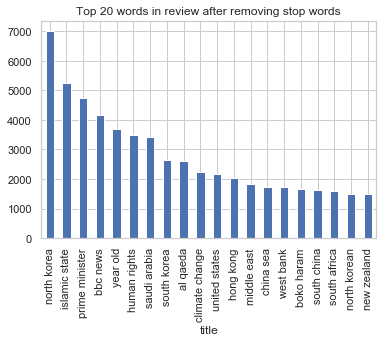

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['title'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['title' , 'count'])
# ploty is not displaying images when viewed from github so used a simpler bar plot
#df2.groupby('title').sum()['count'].sort_values(ascending=False).iplot(
 #   kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')
    
dfn = df2.groupby('title').sum()['count'].sort_values(ascending=False)

dfn.plot.bar(title='Top 20 words in review after removing stop words')    

## Word cloud of the most used words for over 18 blogs title

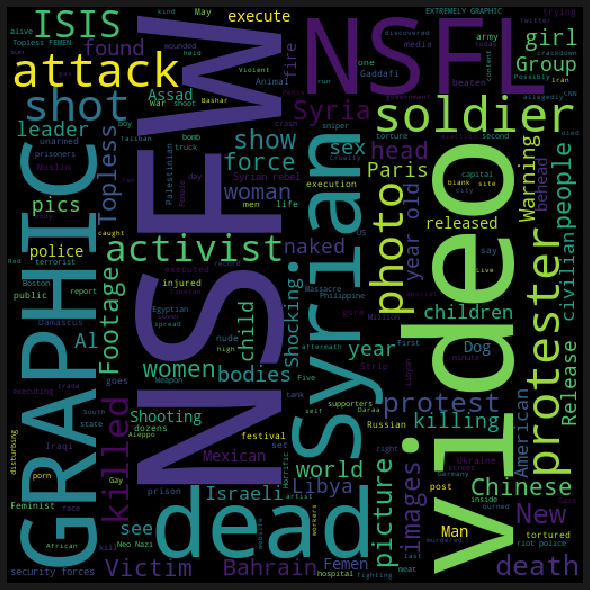

In [14]:
# Word cloud of most used words for over 18 blogs title
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_words = ' '.join(list(df[df['over_18'] == 1]['title']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Word cloud of the most used words for below 18 blogs title

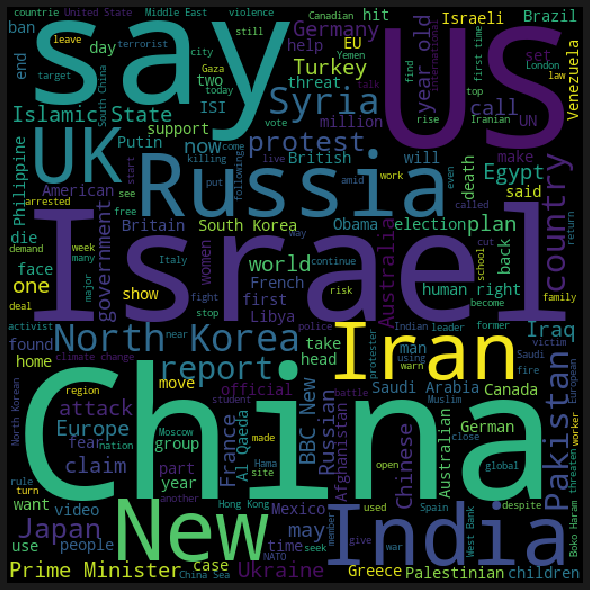

In [15]:
spam_words = ' '.join(list(df[df['over_18'] == 0]['title']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Most up voted blog

By knowing which author is the most up voted we can provide more advertisement in his/her blog post so there is highly possibility that people will see it and view it. Also, we can understand what people like to read the most and create more blogs similar to this context for more viewership and AD revenues. 

In [16]:
up_votes_sorted = df.sort_values(by ='up_votes',ascending=False)

In [17]:
up_votes_sorted.head()

,date_created,up_votes,title,over_18,author,year,day_of_week,season
168034,2013-03-23,2960,Twitter sued £32m for refusing to reveal anti-...,0,anutensil,2013,5,1
192941,2013-06-27,2960,A mysterious Facebook character from Zimbabwe ...,0,DougBolivar,2013,3,2
133351,2012-08-25,2960,Navy advisor stripped of her career for alerti...,0,MAAATLLLOOOCK,2012,5,2
286930,2014-07-04,2959,African leaders should not be prosecuted for w...,0,samueloakford,2014,4,2
218276,2013-10-04,2958,"Swiss to vote on 2,500 franc basic income for ...",0,rstevens94,2013,4,3


## Top 10 above 18 blog authors

In [18]:
df.groupby('author')['over_18'].sum().sort_values(ascending=False).reset_index().head(10)

,author,over_18
0,readerseven,6
1,SyrianGuy,4
2,Rocker13666,4
3,ScotiaTide,4
4,downtown14,3
5,misterAction,3
6,uptodatepronto,3
7,Barack-OJimmy,2
8,URPerfect,2
9,pets_or_meat,2


## Most voted blog from 2008-2016

In [19]:
data.loc[data['up_votes'].idxmax()].reset_index()

,index,377200
0,time_created,1434818471
1,date_created,2015-06-20
2,up_votes,21253
3,down_votes,0
4,title,A biotech startup has managed to 3-D print fak...
5,over_18,False
6,author,KRISHNA53
7,category,worldnews
8,year,2015
9,season,2


## Yearly and season hit blogs

By knowing the yearly and season hit blogs we can understand the trend of blogs people like to read. We can use this data to recommend users the most up votes/viewed blogs. 

In [20]:
hit_blogs = []
season_hit_flag =[]
for i in df['year'].unique():
    # get data for a particular year
    dfy = data.drop(data[data.year !=i].index)
    
    for j in dfy['season'].unique():
        # get data for a particular season
        dfs = dfy.loc[dfy['season'] == j]
        # get the maximum up vote row and append it to the lists
        season_hit_flag.append(dfs.loc[dfs['up_votes'].idxmax()].reset_index())
    
    hits = [i] + dfy.loc[dfy['up_votes'].idxmax()].reset_index().values.tolist() + season_hit_flag
    hit_blogs.append(hits)
    season_hit_flag = []

In [21]:
# Hit blogs contains year number,most upvoted blogs of the year,season hit blogs 
# we can seperate it out to get convert this information for recommendation
# for the year 2008 the output is shown below
hit_blogs[0]

[2008,
 ['time_created', 1230625917],
 ['date_created', '2008-12-30'],
 ['up_votes', 1856],
 ['down_votes', 0],
 ['title',
  'Today Israel takes down an entire apt building of civilians to kill the family of one man. In Canada, we call that  terrorism.'],
 ['over_18', False],
 ['author', 'silencergroup'],
 ['category', 'worldnews'],
 ['year', 2008],
 ['season', 0],
           index                                              22355
 0  time_created                                         1230625917
 1  date_created                                         2008-12-30
 2      up_votes                                               1856
 3    down_votes                                                  0
 4         title  Today Israel takes down an entire apt building...
 5       over_18                                              False
 6        author                                      silencergroup
 7      category                                          worldnews
 8          year    

# Conclusions

From the above analysis we can interpert the following insights- 

1) After finding the popular author based on up votes, we can increase our AD revenus by showing users relevant AD's on those pages.

2) Predict the number of up votes/down votes based on given title using machine learning 

3) Find the best author to provide ranks based on up votes and rewards.

4) Find most unpopular and popular blogs in each gene for users recommendation 

